Files already downloaded and verified
Files already downloaded and verified


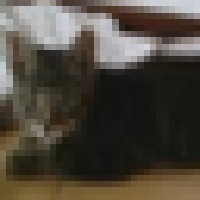

{'airplane': 0, 'automobile': 0, 'bird': 0, 'cat': 1, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0, 'ood': 0, 'flip': 0}


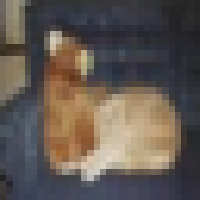

{'airplane': 0, 'automobile': 0, 'bird': 0, 'cat': 1, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0, 'ood': 0, 'flip': 0}


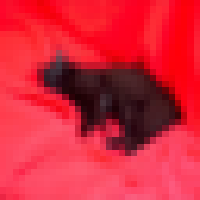

{'airplane': 0, 'automobile': 0, 'bird': 0, 'cat': 1, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0, 'ood': 0, 'flip': 0}


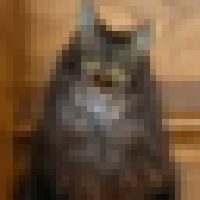

{'airplane': 0, 'automobile': 0, 'bird': 0, 'cat': 1, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0, 'ood': 0, 'flip': 0}


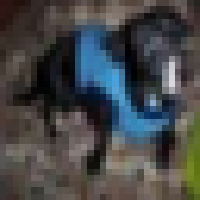

{'airplane': 0, 'automobile': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 1, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0, 'ood': 0, 'flip': 0}


In [1]:
import torch
import torchvision
import numpy as np
import PIL.Image
import PIL.ImageShow

cifar_data = {
    'train': torchvision.datasets.CIFAR10('data', train=True, transform=None, download=True),
    'test': torchvision.datasets.CIFAR10('data', train=False, transform=None, download=True),
}

def show_image(d):
    img = PIL.Image.fromarray(d).resize((200,200), PIL.Image.Resampling.NEAREST)
    PIL.ImageShow.IPythonViewer().show(img)

class Data:
    def __init__(self, kind, n, filters, ood=False, flip=False):
        c = cifar_data[kind]
        want_ts = set(c.class_to_idx[s] for s in filters)
        indices = [i for i,t in enumerate(c.targets) if t in want_ts]
        if len(indices) < n:
            raise Exception(f"Wanted {n} datapoints but only have {len(indices)}")
            
        self.c = c
        self.indices = indices[:n]
        self.flip = flip
        
        self.labels = []
        for i in indices:
            orig_y = c.targets[i]
            labels = {label:1 if j==orig_y else 0 for j,label in enumerate(c.classes)}
            labels['ood'] = 1 if ood else 0
            labels['flip'] = 1 if flip else 0
            self.labels.append(labels)
        
    def __len__(self):
        return len(self.indices)
    
    def _do_transform(self, data):
        if self.flip:
            data = np.flip(data, axis=0)
        return data
    
    def __getitem__(self, idx):
        if not isinstance(idx,int) or idx < 0 or idx >= len(self.indices):
            raise Exception(f"Bad index: {idx}")
        data = self.c.data[self.indices[idx]]
        return self._do_transform(data), self.labels[idx]
        
class DataConcat:
    def __init__(self, *data):
        if len(data) == 0:
            raise Exception("Cannot have empty data")
        self.data = data
        
    def __len__(self):
        return sum(len(d) for d in self.data)
    
    def __getitem__(self, idx):
        if not isinstance(idx,int) or idx < 0 or idx >= len(self):
            raise Exception(f"Bad index: {idx}")
        for d in self.data:
            length = len(d)
            if idx < length:
                return d[idx]
            idx -= length

def show_examples():            
    d = Data('train', n=10000, filters=['cat','dog'])
    for i in range(5):
        x,y = d[i]
        show_image(x)
        print(y)

show_examples()

In [2]:
import time

class Model(torch.nn.Module):
    def __init__(self, outputs:list[str]):
        super().__init__()
        self.outputs = outputs
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(64, 32, 4),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(288, len(outputs)),
        )

    def forward(self, x):
        xp = torch.permute(x, (0, 3, 1, 2)).to(torch.float)
        y = self.layers(xp)
        return {output:y[:,i] for i,output in enumerate(self.outputs)}

def dog_loss(outputs, targets):
    return torch.dist(outputs['dog'], targets['dog'])

def dog_metrics(model, inputs, targets):
    outputs = model(inputs)
    return {
        'accuracy': (torch.round(outputs['dog']) == targets['dog']).to(torch.int).sum()
    }

def experiment(model_class, outputs:list, train, test, loss, metrics, max_epochs=10, max_minutes=5, lr=0.0001):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)

    num_outputs = len(train[0][1])
    model = model_class(outputs=outputs).to(device)
    dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
    dataloader_test = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    start_time = time.monotonic()
    for epoch in range(max_epochs):
        running_loss = torch.zeros(()).to(device)
        running_n = 0
        for X,targets in dataloader:
            X = X.to(device)
            targets = {field:y.to(device) for field,y in targets.items()}
            opt.zero_grad()
            outputs = model(X)
            loss_value = loss(outputs, targets)
            loss_value.backward()
            opt.step()
            running_loss += loss_value.detach()
            running_n += X.shape[0]
        print('Epoch', epoch, '   Loss', running_loss.item())
        
        with torch.no_grad():
            metric_sums = None
            count = 0
            for X,targets in dataloader_test:
                X = X.to(device)
                targets = {field:y.to(device) for field,y in targets.items()}
                metric_dict = metrics(model, X, targets)
                if metric_sums == None:
                    metric_sums = metric_dict
                else:
                    for k,v in metric_dict.items():
                        metric_sums[k] += v
                count += X.shape[0]
            string = ''
            for k,v in metric_sums.items():
                print('   ', k, v.item() / count)
        if time.monotonic() - start_time > max_minutes * 60:
            print("Run out of time!")
            break
    print('Time taken', time.monotonic() - start_time, ' seconds')
    
experiment(
    Model,
    outputs=['dog'],
    train=Data('train', n=10000, filters=['cat','dog']),
    test=Data('test', n=2000, filters=['cat','dog']),
    loss=dog_loss,
    metrics=dog_metrics,
)


cuda:0
Epoch 0    Loss 627.1509399414062
    accuracy 0.6025
Epoch 1    Loss 594.8735961914062
    accuracy 0.637
Epoch 2    Loss 582.4677124023438
    accuracy 0.655
Epoch 3    Loss 570.8466796875
    accuracy 0.663
Epoch 4    Loss 556.4698486328125
    accuracy 0.6705
Epoch 5    Loss 540.3063354492188
    accuracy 0.69
Epoch 6    Loss 525.644775390625
    accuracy 0.6955
Epoch 7    Loss 514.288818359375
    accuracy 0.697
Epoch 8    Loss 502.27947998046875
    accuracy 0.7035
Epoch 9    Loss 494.1283264160156
    accuracy 0.713
Time taken 13.838636019999967  seconds
